In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import sklearn.preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Conv2D
from tensorflow.keras.models import Sequential, Model


C:\Anaconda\envs\data1030\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda\envs\data1030\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Anaconda\envs\data1030\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv("data/flattened_data.csv", index_col = "datetime")

In [3]:
df.dtypes

1INCHBUSD_open      float64
1INCHBUSD_high      float64
1INCHBUSD_low       float64
1INCHBUSD_close     float64
1INCHBUSD_volume    float64
                     ...   
ZRXUSD_open         float64
ZRXUSD_high         float64
ZRXUSD_low          float64
ZRXUSD_close        float64
ZRXUSD_volume       float64
Length: 1955, dtype: object

In [4]:
# check if market bearish
df2 = df.copy()
print(df.shape)
ilist = []
for i in range(len(df.columns)):
    if i%5!=3:
        ilist.append(i)
df2 = df2.drop(df.columns[ilist],axis = 1)
print(df2.shape)
price_list = df2.iloc[0]
print(len(price_list))

(3624, 1955)
(3624, 391)
391


In [5]:
# Normalize the data ¯\_(ツ)_/¯
x = df.values #returns a numpy array
df = pd.DataFrame(x, columns = df.columns)
df.head

<bound method NDFrame.head of       1INCHBUSD_open  1INCHBUSD_high  1INCHBUSD_low  1INCHBUSD_close  \
0              2.410           2.450          2.406            2.429   
1              2.434           2.441          2.421            2.424   
2              2.423           2.444          2.418            2.434   
3              2.433           2.449          2.433            2.435   
4              2.436           2.454          2.415            2.428   
...              ...             ...            ...              ...   
3619           0.967           0.972          0.953            0.964   
3620           0.963           0.965          0.960            0.965   
3621           0.964           0.964          0.958            0.961   
3622           0.960           0.966          0.953            0.965   
3623           0.965           0.981          0.961            0.978   

      1INCHBUSD_volume  1INCHUSD_open  1INCHUSD_high  1INCHUSD_low  \
0              27034.1          2.3

In [6]:

## split the dataset into 70:15:15
last_15 = sorted(df.index.values)[-int(0.15*len(df))] # Last 15% indices
last_30 = sorted(df.index.values)[-int(0.3*len(df))] 

train_data = df[(df.index < last_30)].values
val_data = df[(df.index >= last_30) & (df.index < last_15)].values
test_data = df[(df.index >= last_15)].values

print('Training set shape: {}'.format(train_data.shape))
print('Validation set shape: {}'.format(val_data.shape))
print('Test data set: {}'.format(test_data.shape))
# standardize the dataset
scaler = sklearn.preprocessing.MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)
# reshape the data with to window size
seq_len = 336 #30

def reshape_data(seq_len, data):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[:][i])
    X, y = np.array(X), np.array(y)
    return X, y

x_train, y_train = reshape_data(seq_len, train_data)
x_val, y_val = reshape_data(seq_len, val_data)
x_test, y_test = reshape_data(seq_len, test_data)

print('Training set shape', x_train.shape, y_train.shape)
print('Validation set shape', x_val.shape, y_val.shape)
print('Testing set shape' ,x_test.shape, y_test.shape)
print(df.shape)


Training set shape: (2537, 1955)
Validation set shape: (544, 1955)
Test data set: (543, 1955)
Training set shape (2201, 336, 1955) (2201, 1955)
Validation set shape (208, 336, 1955) (208, 1955)
Testing set shape (207, 336, 1955) (207, 1955)
(3624, 1955)


In [7]:
n_steps_in = seq_len# Same as sequence length
n_steps_out = 1
# [samples, timesteps, features]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_val.shape)
print('y_valid.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
n_features = x_train.shape[2]

x_train.shape =  (2201, 336, 1955)
y_train.shape =  (2201, 1955)
x_valid.shape =  (208, 336, 1955)
y_valid.shape =  (208, 1955)
x_test.shape =  (207, 336, 1955)
y_test.shape =  (207, 1955)


In [8]:
profit = 0
x_test_last = x_test[:, -1, :]

print(x_test_last.shape)
x_test_last_close = []
y_test_close = []
y_test_pred_close = []
for i in range(x_test_last.shape[1]):
    if i%5 ==3:
        x_test_last_close.append(x_test_last[:,i])
        y_test_close.append(y_test[:,i])
        # y_test_pred_close.append(y_test_pred[:,i])
x_test_last_close = np.transpose(np.array(x_test_last_close))
y_test_close = np.transpose(np.array(y_test_close))
# y_test_pred_close = np.transpose(np.array(y_test_pred_close))
print(x_test_last_close.shape)
print(y_test_close.shape)
# print(y_test_pred_close.shape)

loss_money = 0
profit_money = 0
for i in range(x_test_last_close.shape[0]):
    for j in range(x_test_last_close.shape[1]):
        if x_test_last_close[i,j] != 0:
            profit = profit - 1000 + 1000*(y_test_close[i, j]/x_test_last_close[i,j])
print(profit)


(207, 1955)
(207, 391)
(207, 391)
176747.30788388048


In [11]:
seq_len = 30 # choose sequence length
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

In [16]:
# [samples, timesteps, features]
print('X_train.shape',x_train.shape)
print('y_train.shape', y_train.shape)
print('X_valid.shape',x_val.shape)
print('y_valid.shape', y_val.shape)
print('X_test.shape', x_test.shape)
print('y_test.shape',y_test.shape)
n_features = x_train.shape[2]

X_train.shape (2201, 336, 1955)
y_train.shape (2201, 1955)
X_valid.shape (208, 336, 1955)
y_valid.shape (208, 1955)
X_test.shape (207, 336, 1955)
y_test.shape (207, 1955)


In [22]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(dropout_ratio))
model.add(Dense(n_steps_out*n_features))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                517120    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1955)              127075    
                                                                 
Total params: 644,195
Trainable params: 644,195
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_fit = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epoch,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 2201 samples, validate on 208 samples
Epoch 1/10
2201/2201 [==============================] - 25s 11ms/sample - loss: 0.0373 - val_loss: 0.0332
Epoch 2/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0090 - val_loss: 0.0235
Epoch 3/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0068 - val_loss: 0.0221
Epoch 4/10
2201/2201 [==============================] - 23s 11ms/sample - loss: 0.0053 - val_loss: 0.0215
Epoch 5/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0048 - val_loss: 0.0220
Epoch 6/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0043 - val_loss: 0.0218
Epoch 7/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0041 - val_loss: 0.0214
Epoch 8/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0038 - val_loss: 0.0216
Epoch 9/10
2201/2201 [==============================] - 24s 11ms/sample - loss: 0.0036 - val_loss: 0.0216

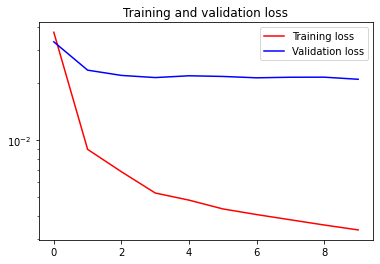

<Figure size 432x288 with 0 Axes>

In [25]:
plt.yscale('log')
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [26]:
model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)

5.123106381860021e+16

In [29]:
y_test.shape
y_test_pred= model.predict(x_test)

In [30]:
y_test_pred.shape

(207, 1955)

In [32]:
x_test_last = x_test[:, 28, :]
y_true_change = []
y_pred_change = []
for i in range(y_test.shape[1]):
    temp_true_change = []
    temp_pred_change = []
    for j in range(y_test.shape[0]):
        temp_true_change.append(y_test[j,i]-x_test_last[j,i])
        temp_pred_change.append(y_test_pred[j,i]-x_test_last[j,i])
    y_true_change.append(temp_true_change)
    y_pred_change.append(temp_pred_change)
y_true_change = np.array(y_true_change)
y_pred_change = np.array(y_pred_change)

In [33]:
sgn_change = []
for i in range(y_pred_change.shape[1]):
    # append average accuracy of sign equality
    s = 0
    for j in range(y_pred_change.shape[0]):
        if ((y_true_change[j, i]*y_pred_change[j, i]) >= 0):
        #currently ignoring where no change predicted or seen
            s = s+1
    sgn_change.append(s/y_pred_change.shape[0])
print(sum(sgn_change)/len(sgn_change))

0.4966776628735928


In [34]:
from sklearn.metrics import r2_score
r2_array = []
for i in range(y_test.shape[1]):
    r2_array.append(r2_score(np.array(y_test[:, i]), np.array(y_test_pred[:, i])))

In [43]:
print('mean value of the r2 array:', np.mean(r2_array))
print('median value of the r2 array:', np.median(r2_array))

mean value of the r2 array: -1.5680408080312068e+21
median value of the r2 array: -2.8467896605809234e+19


In [35]:
import statistics
print(statistics.median(r2_array))

-2.8467896605809234e+19
